In [1]:
from google.colab import drive
import os

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/Colab Notebooks/Data Science/Code" 
PROJECT_PATH = os.path.join(ROOT, PROJ)

# PROJECT_PATH = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip3 install --quiet isodate

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math
import isodate
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [0]:
data_path = os.path.join(PROJECT_PATH, 'DS/mohit_youtube_wh_ds.csv')
df = pd.read_csv(data_path).drop(['titleUrl', 
                                  'snippet.defaultLanguage',
                                  'contentDetails.regionRestriction.allowed',
                                  'contentDetails.regionRestriction.blocked',
                                  'contentDetails.contentRating.ytRating'], axis=1).\
                                  dropna(subset = ['contentDetails.duration'])


In [5]:
df.head(10)

,time,videoId,contentDetails.caption,contentDetails.definition,contentDetails.dimension,contentDetails.duration,contentDetails.licensedContent,contentDetails.projection,id,snippet.categoryId,snippet.channelId,snippet.channelTitle,snippet.description,snippet.liveBroadcastContent,snippet.publishedAt,snippet.tags,snippet.title,statistics.commentCount,statistics.dislikeCount,statistics.favoriteCount,statistics.likeCount,statistics.viewCount,status.embeddable,status.license,status.privacyStatus,status.publicStatsViewable,status.uploadStatus,snippet.defaultAudioLanguage
0,2019-09-24T12:22:19.156Z,RPPi67D3CCE,False,hd,2d,PT10M13S,True,rectangular,RPPi67D3CCE,24.0,UCZT_OWY9abyO3V9Rmdvh02w,Viralbollywood,Bigg Boss Host Salman khan INTRODUCES Ameesha ...,none,2019-09-23T13:04:01.000Z,"['bigg boss 13', 'bigg boss 13 contestants', '...",Salman khan INTRODUCES Ameesha Patel In Bigg B...,2860.0,5202.0,0.0,76261.0,8232043.0,True,youtube,public,False,processed,hi
1,2019-09-24T12:21:49.959Z,E-oXUNiM_pw,False,hd,2d,PT3M36S,True,rectangular,E-oXUNiM_pw,24.0,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,Urvashi Rautela finally talked about the viral...,none,2019-09-23T13:11:40.000Z,"['Urvashi rautela', 'Boney kapoor', 'Urvashi b...",Urvashi Rautela के साथ Video Viral होने के बाद...,448.0,345.0,0.0,3962.0,174033.0,True,youtube,public,True,processed,hi
2,2019-09-24T11:54:51.923Z,PVxc5mIHVuQ,False,hd,2d,PT4M30S,True,rectangular,PVxc5mIHVuQ,10.0,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,Gulshan Kumar presents Bhushan Kumar's PACHTAO...,none,2019-08-23T09:34:08.000Z,"['pachtaoge song', 'Nora Fatehi', 'pachtaoge s...","Arijit Singh: Pachtaoge | Vicky Kaushal, Nora ...",115954.0,167252.0,0.0,3414944.0,231692337.0,True,youtube,public,False,processed,hi
3,2019-09-24T11:39:05.171Z,QCXaa1mEUK0,True,hd,2d,PT3M44S,True,rectangular,QCXaa1mEUK0,10.0,UCdNZZ9znjaiOXNi004mHxSg,Indie Music Label,The wait for the annual monsoon song ends here...,none,2019-07-18T05:30:03.000Z,"['indie music label', 'darshan raval', 'hawa b...",Darshan Raval - Hawa Banke | Official Music Vi...,43414.0,46885.0,0.0,1420364.0,82268049.0,True,youtube,public,True,processed,en
4,2019-09-24T07:39:41.078Z,XatRGut65VI,True,hd,2d,PT2M45S,True,rectangular,XatRGut65VI,24.0,UC4zWG9LccdWGUlF77LZ8toA,Amazon Prime Video India,The Family Man Season 1 Official Trailer 2019....,none,2019-09-05T07:48:03.000Z,"['the family man trailer', 'the family man', '...",The Family Man – Official Trailer | Raj & DK |...,4518.0,2605.0,0.0,86869.0,22339637.0,True,youtube,public,True,processed,en
5,2019-09-24T07:34:09.069Z,-uA-ONin_5M,True,hd,2d,PT3M7S,True,rectangular,-uA-ONin_5M,24.0,UCqZR7KVVsZRSfezZKJllxVQ,Reliance Entertainment,"Before 1998, Johri village in the interiors of...",none,2019-09-23T08:29:39.000Z,"['Taapsee Pannu', 'Bhumi Pednekar', 'Saand Ki ...",Saand Ki Aankh | Official Trailer| Bhumi Pedne...,10085.0,15504.0,0.0,303246.0,20595612.0,True,youtube,public,True,processed,hi
6,2019-09-24T06:31:30.053Z,VbEQriZEfoI,True,hd,2d,PT9M52S,False,rectangular,VbEQriZEfoI,25.0,UC4xKdmAXFh4ACyhpiQ_3qBw,TechLead,Ex-Google/ex-Facebook TechLead exposes the rec...,none,2019-09-23T14:02:07.000Z,"['facebook', 'suicide', 'facebooksuicide', 'de...",Facebook Employee Suicide Cover-Up,2556.0,304.0,0.0,25200.0,470651.0,True,youtube,public,True,processed,en
7,2019-09-24T05:55:24.558Z,uyBcViLZyyM,False,hd,2d,PT13M15S,True,rectangular,uyBcViLZyyM,25.0,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,"In this episode of Lallantop Show, Saurabh Dwi...",none,2019-09-23T16:30:02.000Z,"['howdy modi event', 'howdy modi event in hous...",Narendra Modi और Donald Trump ने Howdy Modi के...,2136.0,2049.0,0.0,12394.0,677169.0,True,youtube,public,True,processed,hi
8,2019-09-24T05:47:13.221Z,LudWy_Ytt2c,False,hd,2d,PT3M7S,True,rectangular,LudWy_Ytt2c,25.0,UCm7lHFkt2yB_WzL67aruVBQ,Hindustan Times,"President of the United States of America, Don...",none,2019-09-24T03:52:04.000Z,"['afghanistan', 'donald trump', 'imran khan', ...",Watch Trump's reaction as Imran Khan talk

# Distribution of Top 20 channel of watched videos

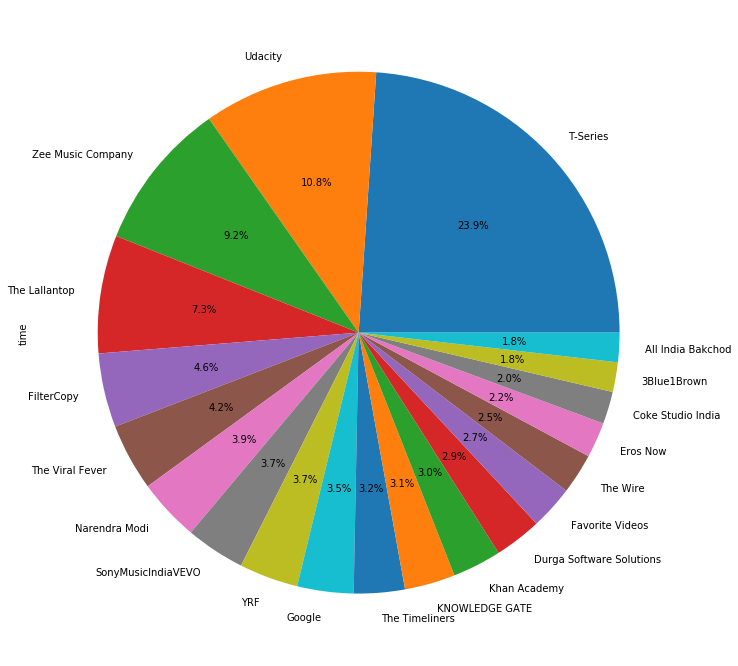

In [6]:
# df.groupby('snippet.channelTitle')['time'].nunique().sort_values(ascending=False).iloc[:20].plot(kind='pie', figsize=(8, 8))

t = df.groupby('snippet.channelTitle')['time'].\
nunique().\
sort_values(ascending=False).\
iloc[:20]

t.plot(kind='pie', 
     autopct='%1.1f%%', 
     shadow=False, 
     labels=t.index.values.tolist(), 
     figsize=(12, 12))

# Distribution of languages of watched videos

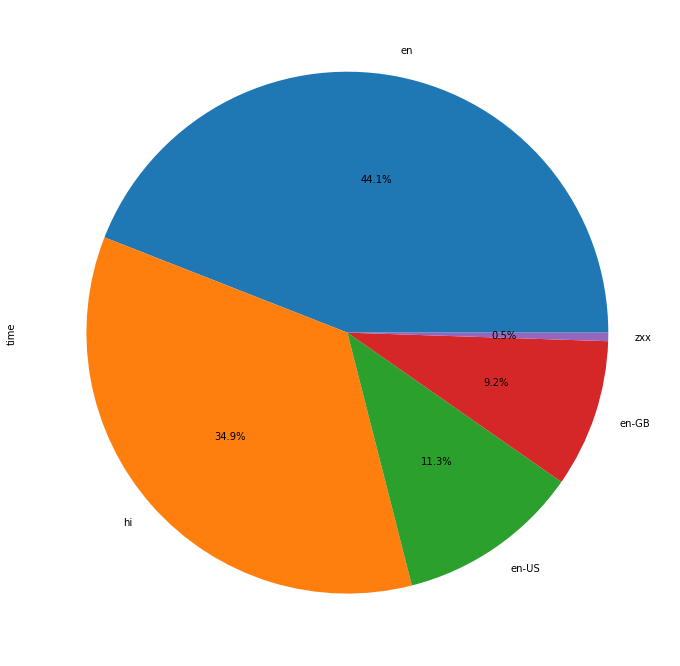

In [7]:
# df.groupby('snippet.defaultAudioLanguage')['time'].nunique().sort_values(ascending=False).iloc[:5].plot.pie(figsize=(8, 8))

t = df.groupby('snippet.defaultAudioLanguage')['time'].\
nunique().\
sort_values(ascending=False).\
iloc[:5]

t.plot(kind='pie', 
     autopct='%1.1f%%', 
     shadow=False, 
     labels=t.index.values.tolist(), 
     figsize=(12, 12))

# Distribution of Categories of watched videos

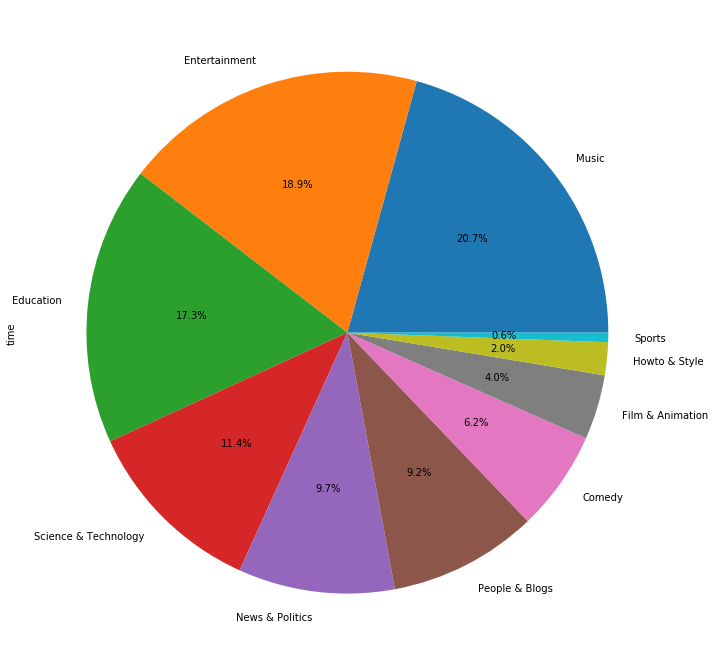

In [8]:
t = df.groupby('snippet.categoryId')['time'].\
nunique().\
sort_values(ascending=False).\
iloc[:10]

category_information = pd.read_csv(os.path.join(PROJECT_PATH, 'DS/all_in_categories.csv')).drop([
                                                                              'snippet.assignable',
                                                                              'snippet.channelId'    
                                                                            ], axis=1)
category_information = category_information.set_index('id')
category_information.loc[1, 'snippet.title']
category_information = category_information.to_dict()
category_information = category_information['snippet.title']

t1 = t.index.values.tolist()
t1 = [category_information[int(i)] for i in t1]

t.plot(kind='pie', 
     autopct='%1.1f%%', 
     shadow=False, 
     labels=t1, 
     figsize=(12, 12))

t1 = list(df['snippet.categoryId'])
def encode(id):
    try:
        return category_information[int(id)]
    except:
        return 'Unkown'
t1 = [encode(i) for i in t1]
df['snippet.categoryId'] = t1

# Time series analysis of content duration

In [0]:
t = list(df['contentDetails.duration'])

for i in range(len(t)):
    try:
      t[i] = isodate.parse_duration(t[i]).total_seconds()
    except:
      print('Exception occured at:', i, 'for', t[i])

df['contentDetails.duration'] = t

In [0]:
t = df[['time', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])

t = t.set_index('time').\
      resample('M').mean().dropna()


Rows: 95


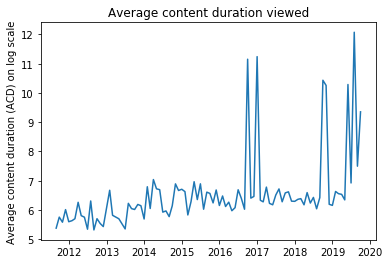

AutoCorrealtion at lag = 1: -0.013820960454198951
AutoCorrealtion at lag = 2: 0.12182010386976047
AutoCorrealtion at lag = 3: 0.18442814981781158

ADF Statistic: -2.520335128116129
p-value: 0.11060463819440836
Critical Values:
	 1% :  -3.503514579651927
	 5% :  -2.893507960466837
	 10% :  -2.583823615311909




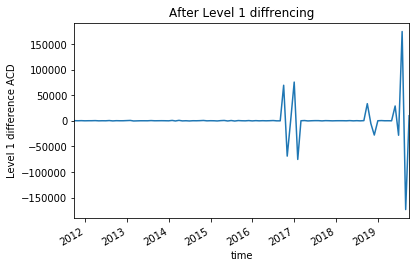

ADF Statistic: -5.6309098430562265
p-value: 1.0900679588503872e-06


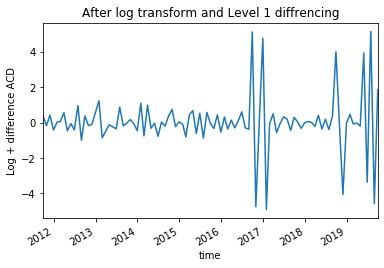

  0%|          | 0/29 [00:00<?, ?it/s]

ADF Statistic: -12.308119910507648
p-value: 7.193739900493205e-23


100%|██████████| 29/29 [00:11<00:00,  2.65it/s]

MSE: 2.9851470923894556


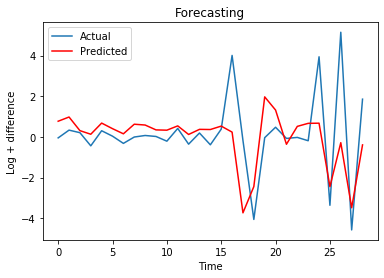

R square score: 0.22427445398839851


In [11]:
print('Rows:', t.shape[0])
plt.plot(t.index.values, np.log(t['contentDetails.duration']))
plt.ylabel('Average content duration (ACD) on log scale')
plt.title('Average content duration viewed')
plt.show()

print('AutoCorrealtion at lag = 1:', t['contentDetails.duration'].autocorr(lag=1))
print('AutoCorrealtion at lag = 2:', t['contentDetails.duration'].autocorr(lag=2))
print('AutoCorrealtion at lag = 3:', t['contentDetails.duration'].autocorr(lag=3), end='\n\n')

# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
X = t['contentDetails.duration'].values
res = adfuller(X)
print('ADF Statistic:', res[0])
print('p-value:', res[1])
print('Critical Values:')
for k, v in res[4].items():
	print('\t', k, ': ', v)
print('\n')


# ----------------------------------------------------------------------

# Converting non-stationarity to stationarity.
t['contentDetails.duration_d'] = t['contentDetails.duration'] - t['contentDetails.duration'].shift(1)
t['contentDetails.duration_d'].dropna().plot()
plt.ylabel('Level 1 difference ACD')
plt.title('After Level 1 diffrencing')
plt.show()

# Augmented Dickey-Fuller test
X = t['contentDetails.duration_d'].dropna().values
res = adfuller(X)
print('ADF Statistic:', res[0])
print('p-value:', res[1])

# -------------------------------------------------------------------------

# Log transform
t['contentDetails.duration_l'] = np.log(t['contentDetails.duration'])

# Converting log-non-stationarity to stationarity.
t['contentDetails.duration_ld'] = t['contentDetails.duration_l'] - t['contentDetails.duration_l'].shift(1)
t['contentDetails.duration_ld'].dropna().plot()
plt.ylabel('Log + difference ACD')
plt.title('After log transform and Level 1 diffrencing')
plt.show()

# Augmented Dickey-Fuller test
X = t['contentDetails.duration_ld'].dropna().values
res = adfuller(X)
print('ADF Statistic:', res[0])
print('p-value:', res[1])

# -------------------------------------------------------------------------

# Fit ARMA Model
X = t['contentDetails.duration_ld'].dropna().values
size = int(len(X) * 0.70)

train = X[0:size]
test = X[size:len(X)]

history = [x for x in train]
predict = []

for t in tqdm(range(len(test))):
	model = ARIMA(history, order=(4,0,1)).fit()
	predict.append(model.forecast()[0])
	history.append(test[t])
    
print('MSE:', mean_squared_error(test, predict))
plt.plot(test, label='Actual')
plt.plot(predict, color='red', label='Predicted')
plt.legend()
plt.ylabel('Log + difference')
plt.xlabel('Time')
plt.title('Forecasting')
plt.show()

print('R square score:', r2_score(test, predict))

# Trend in duration of watched content month wise.

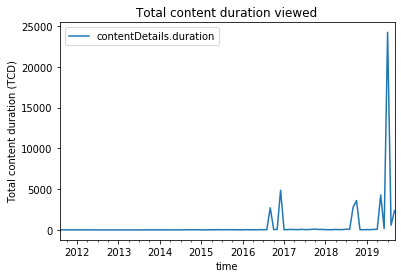

In [12]:
t = df[['time', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])

t = t.set_index('time').\
      resample('M').sum().dropna()

t['contentDetails.duration'] = t['contentDetails.duration'].apply(lambda x: x/3600)

t.plot(y=['contentDetails.duration'])
plt.ylabel('Total content duration (TCD)')
plt.title('Total content duration viewed')
plt.show()

# Trend in duration of watched content year wise.

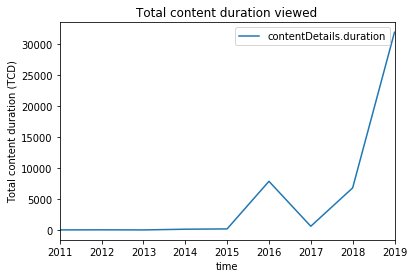

In [13]:
t = df[['time', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])

t = t.set_index('time').\
      resample('Y').sum().dropna()

t['contentDetails.duration'] = t['contentDetails.duration'].apply(lambda x: x/3600)

t.plot(y=['contentDetails.duration'])
plt.ylabel('Total content duration (TCD)')
plt.title('Total content duration viewed')
plt.show()

# Distrbution of duration of watched content between day and night month wise

In [14]:
t = df[['time', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])

day = t[(t['time'].dt.hour > 7) & (t['time'].dt.hour <= 20)]

day = day.set_index('time').\
      resample('M').sum().dropna()

night = t[(t['time'].dt.hour <= 7) | (t['time'].dt.hour > 20)]

print(night.head())

night = night.set_index('time').\
        resample('M').sum().dropna()

t = t.set_index('time').\
      resample('M').sum().dropna()

                              time  contentDetails.duration
4 2019-09-24 07:39:41.078000+00:00                    165.0
5 2019-09-24 07:34:09.069000+00:00                    187.0
6 2019-09-24 06:31:30.053000+00:00                    592.0
7 2019-09-24 05:55:24.558000+00:00                    795.0
8 2019-09-24 05:47:13.221000+00:00                    187.0


In [15]:
day.head()

,contentDetails.duration
time,
2011-08-31 00:00:00+00:00,7739.0
2011-09-30 00:00:00+00:00,20173.0
2011-10-31 00:00:00+00:00,9322.0
2011-11-30 00:00:00+00:00,28258.0
2011-12-31 00:00:00+00:00,24477.0


In [16]:
night.head()

,contentDetails.duration
time,
2011-08-31 00:00:00+00:00,1359.0
2011-09-30 00:00:00+00:00,3203.0
2011-10-31 00:00:00+00:00,4758.0
2011-11-30 00:00:00+00:00,17460.0
2011-12-31 00:00:00+00:00,11969.0


In [17]:
t.head()

,contentDetails.duration
time,
2011-08-31 00:00:00+00:00,9098.0
2011-09-30 00:00:00+00:00,23376.0
2011-10-31 00:00:00+00:00,14080.0
2011-11-30 00:00:00+00:00,45718.0
2011-12-31 00:00:00+00:00,36446.0


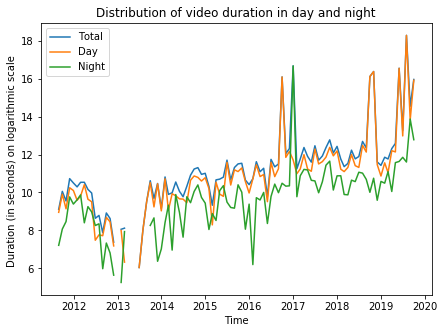

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(t.index, np.log(t['contentDetails.duration']), label="Total")
plt.plot(day.index, np.log(day['contentDetails.duration']), label="Day")
plt.plot(night.index, np.log(night['contentDetails.duration']), label="Night")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Duration (in seconds) on logarithmic scale ')
plt.title('Distribution of video duration in day and night')
plt.show()

# Distrbution of duration of watched content between day and night year wise

                              time  contentDetails.duration
4 2019-09-24 07:39:41.078000+00:00                    165.0
5 2019-09-24 07:34:09.069000+00:00                    187.0
6 2019-09-24 06:31:30.053000+00:00                    592.0
7 2019-09-24 05:55:24.558000+00:00                    795.0
8 2019-09-24 05:47:13.221000+00:00                    187.0


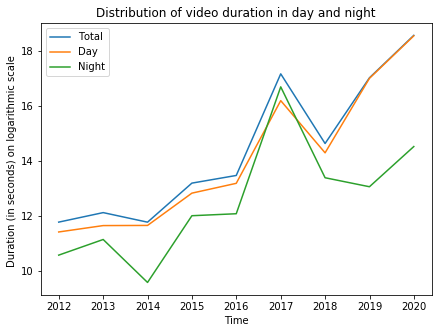

In [19]:
t = df[['time', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])

day = t[(t['time'].dt.hour > 7) & (t['time'].dt.hour <= 20)]

day = day.set_index('time').\
      resample('Y').sum().dropna()

night = t[(t['time'].dt.hour <= 7) | (t['time'].dt.hour > 20)]

print(night.head())

night = night.set_index('time').\
        resample('Y').sum().dropna()

t = t.set_index('time').\
      resample('Y').sum().dropna()


plt.figure(figsize=(7, 5))
plt.plot(t.index, np.log(t['contentDetails.duration']), label="Total")
plt.plot(day.index, np.log(day['contentDetails.duration']), label="Day")
plt.plot(night.index, np.log(night['contentDetails.duration']), label="Night")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Duration (in seconds) on logarithmic scale ')
plt.title('Distribution of video duration in day and night')
plt.show()

# Distrbution of duration of watched content among categories for each year

In [20]:
t = df[['time', 'snippet.categoryId', 'contentDetails.duration']]
t['time'] = pd.to_datetime(t['time'])
t.head()

,time,snippet.categoryId,contentDetails.duration
0,2019-09-24 12:22:19.156000+00:00,Entertainment,613.0
1,2019-09-24 12:21:49.959000+00:00,Entertainment,216.0
2,2019-09-24 11:54:51.923000+00:00,Music,270.0
3,2019-09-24 11:39:05.171000+00:00,Music,224.0
4,2019-09-24 07:39:41.078000+00:00,Entertainment,165.0


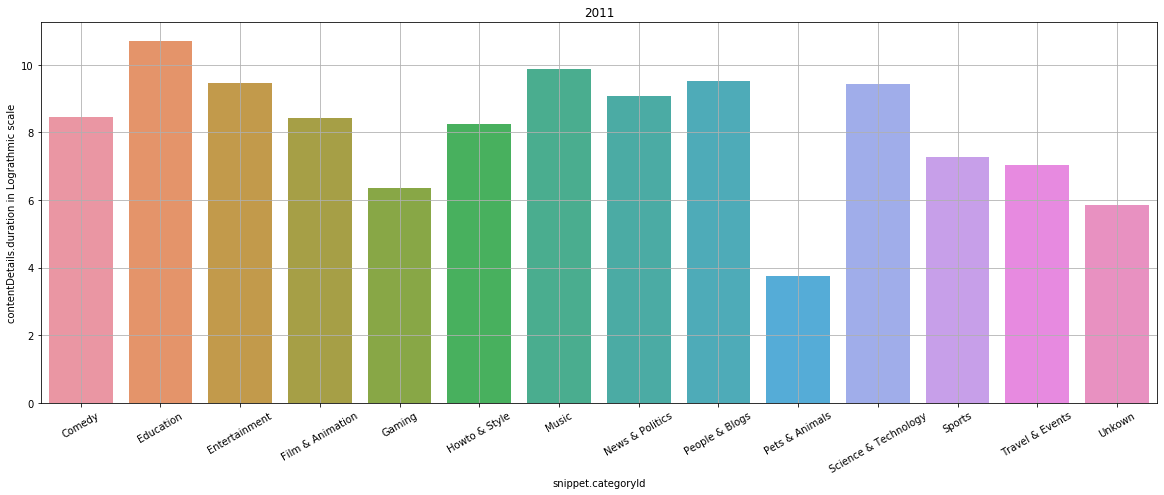

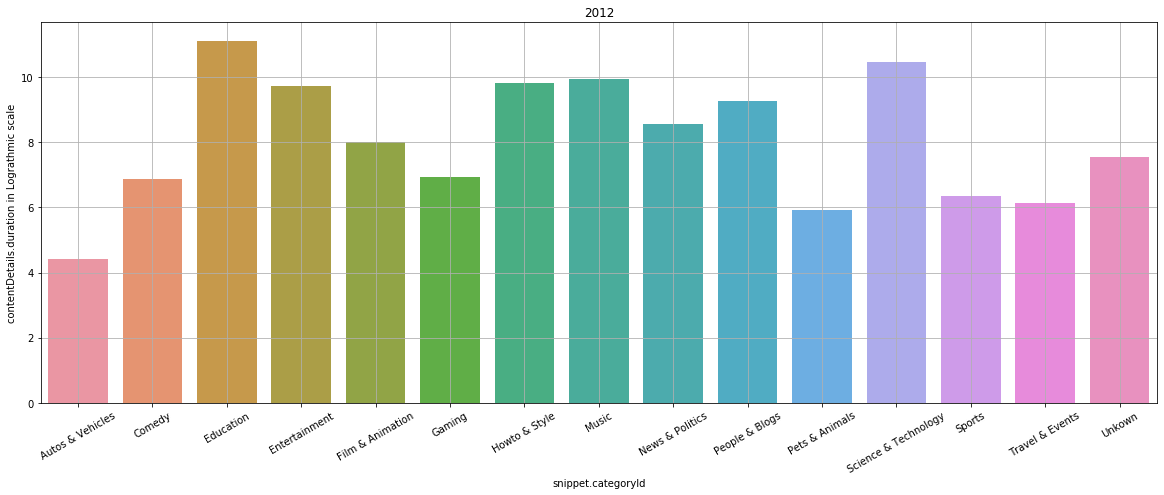

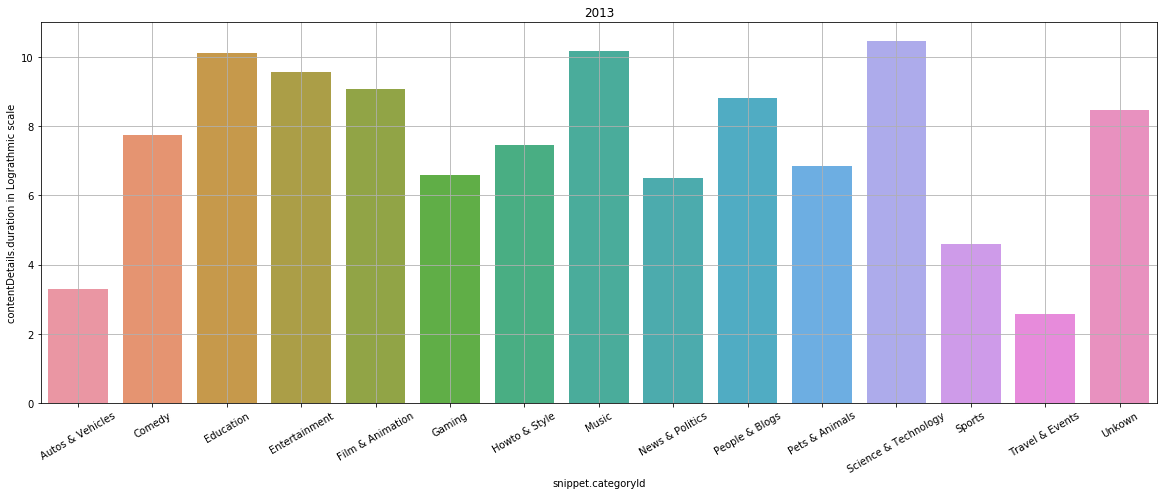

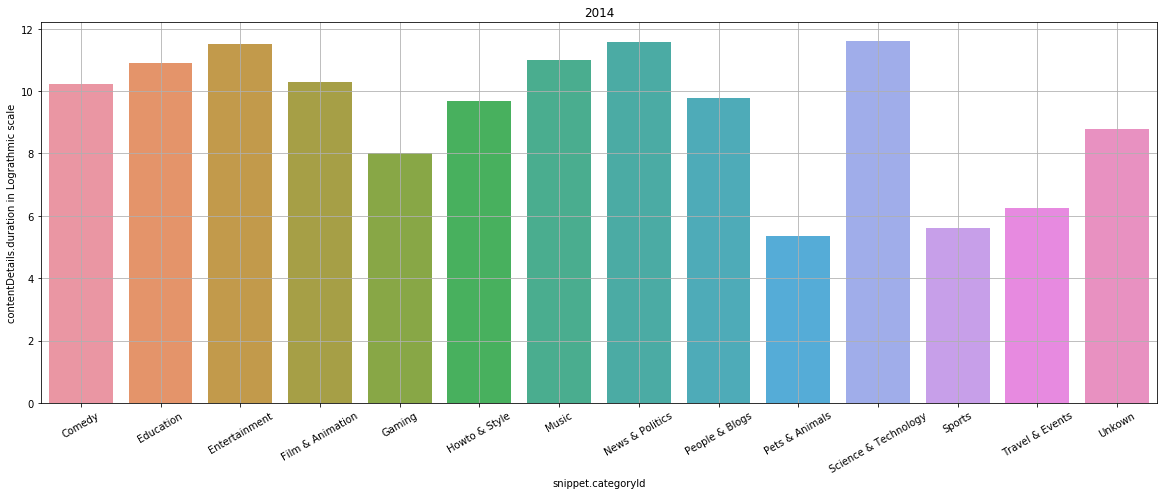

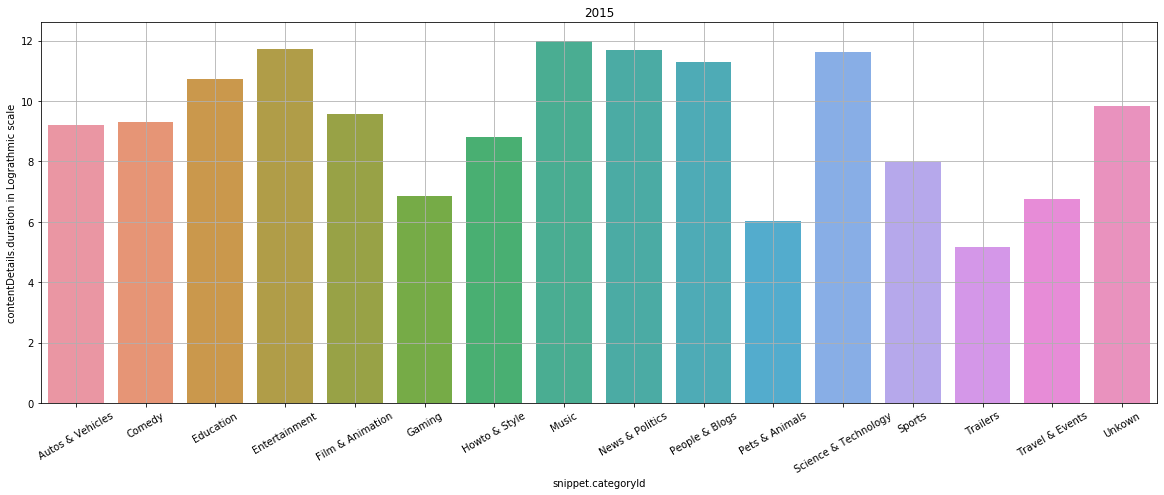

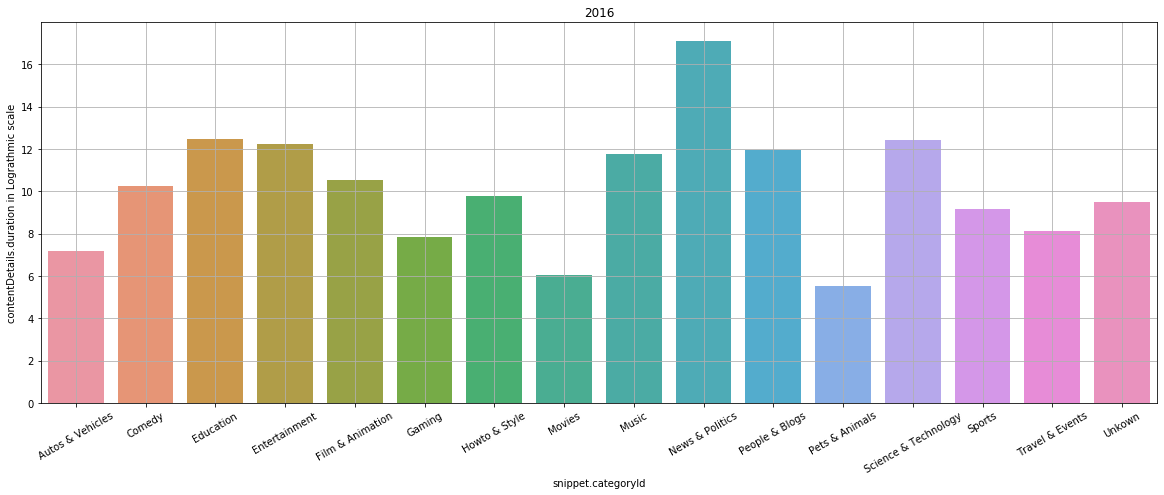

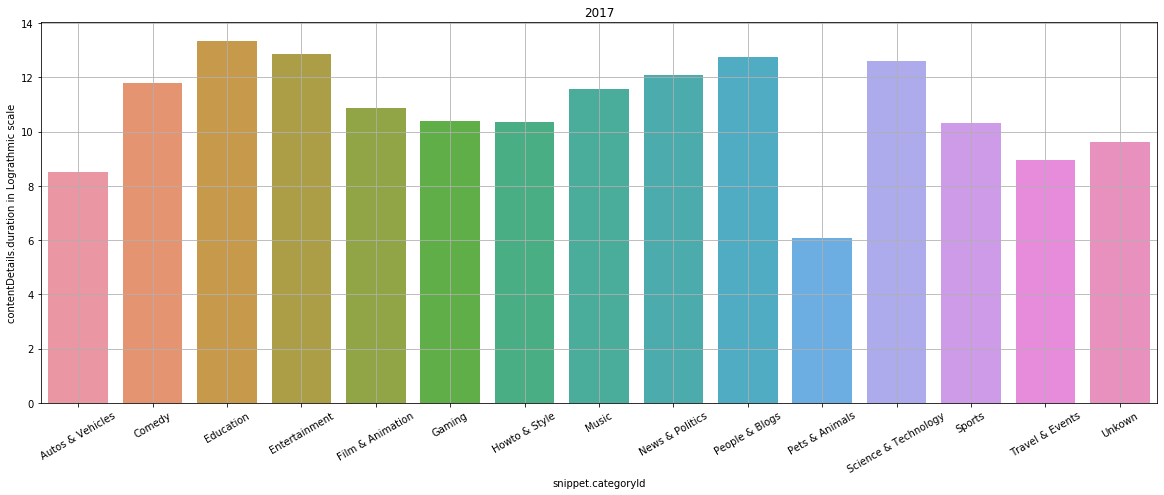

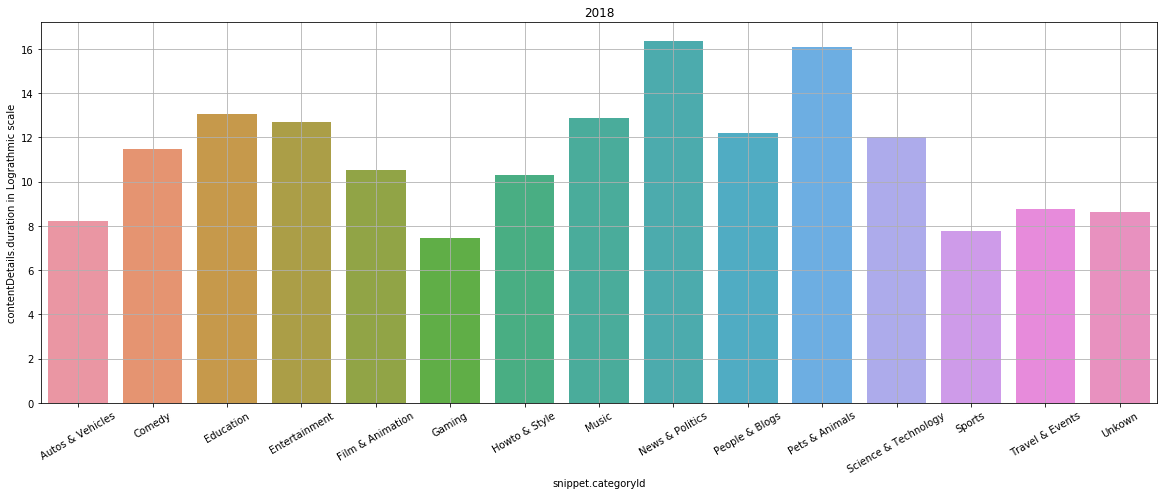

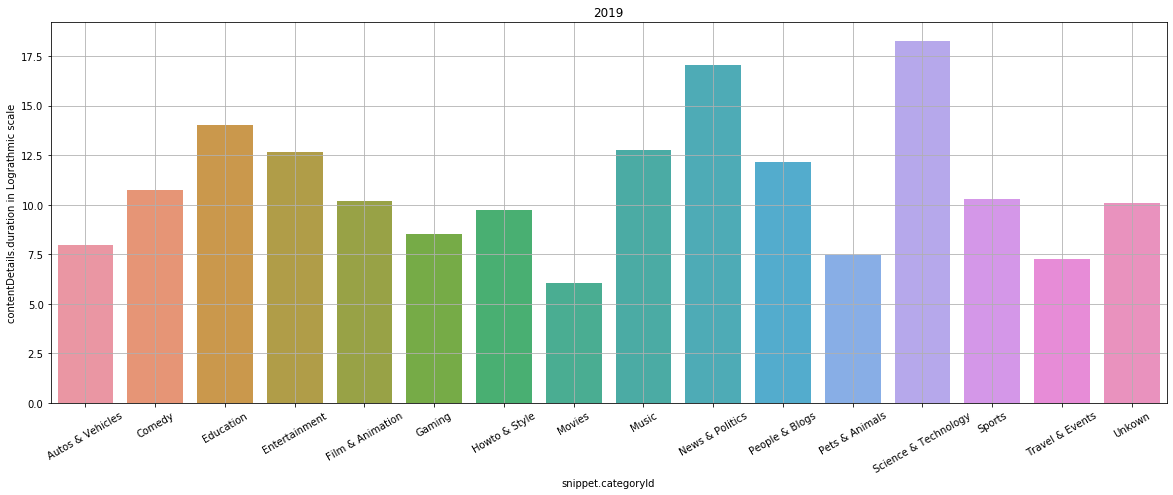

In [21]:
t1 = t.groupby([t.time.dt.year, 'snippet.categoryId']).sum()
t2 = t1.index.values.tolist()
t2 = list(map(list, t2)) 
t2 = [i[0] for i in t2]
t2 = np.unique(t2)
t2 = np.sort(t2)
t1['contentDetails.duration'] = np.log(t1['contentDetails.duration'])

for y in t2:
    t3 = t1.loc[y]
    t3.reset_index(level=0, inplace=True)
    plt.figure(figsize=(20, 7))
    g = sns.barplot(x = 'snippet.categoryId', y='contentDetails.duration', data=t3)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    plt.title(y)
    plt.ylabel('contentDetails.duration in Lograthmic scale')
    plt.grid()
    plt.show()

In [0]:
channel_details = pd.read_csv(os.path.join(PROJECT_PATH, 'DS/channel_details.csv')).drop([
                                                                              'id',
                                                                              'snippet.publishedAt',
                                                                              'statistics.commentCount',
                                                                              'statistics.hiddenSubscriberCount',
                                                                              'statistics.subscriberCount',
                                                                              'statistics.videoCount',
                                                                              'statistics.viewCount',
                                                                              'status.isLinked',
                                                                              'status.longUploadsStatus',
                                                                              'status.privacyStatus',
                                                                              'snippet.defaultLanguage' ], axis=1)
channel_details = channel_details.rename(columns={'channelId':'snippet.channelId'})

In [23]:
channel_details.head()

,snippet.channelId,brandingSettings.channel.keywords,snippet.country,snippet.customUrl,snippet.description,snippet.title
0,UCZT_OWY9abyO3V9Rmdvh02w,"""latest news"" ""latest Bollywood news"" ""bollywo...",IN,viralbollywood,Viral Bollywood Entertainment Private Limited ...,Viralbollywood
1,UCx8Z14PpntdaxCt2hakbQLQ,"""Hindi News"" ""The Lallantop"" ""Latest News"" ""Ce...",IN,thelallantop,दी लल्लनटॉप यूट्यूब चैनल पर स्वागत है. यहां आप...,The Lallantop
2,UCq-Fj5jknLsUf-MWSy4_brA,"""tseries tseries"" t-series ""tseries songs"" ""di...",IN,tseriesmusic,"""Music can change the world"". T-Series is Indi...",T-Series
3,UCdNZZ9znjaiOXNi004mHxSg,"""indie music"" Indiemusic ""Indie Music"" ""indie ...",IN,NaN,We are lovers of music who collaborate with so...,Indie Music Label
4,UC4zWG9LccdWGUlF77LZ8toA,"amazon prime video ""amazon prime video"" ""amazo...",IN,primevideoin,Unlimited ad-free streaming of Amazon Original...,Amazon Prime Video India


In [24]:
df.head()

,time,videoId,contentDetails.caption,contentDetails.definition,contentDetails.dimension,contentDetails.duration,contentDetails.licensedContent,contentDetails.projection,id,snippet.categoryId,snippet.channelId,snippet.channelTitle,snippet.description,snippet.liveBroadcastContent,snippet.publishedAt,snippet.tags,snippet.title,statistics.commentCount,statistics.dislikeCount,statistics.favoriteCount,statistics.likeCount,statistics.viewCount,status.embeddable,status.license,status.privacyStatus,status.publicStatsViewable,status.uploadStatus,snippet.defaultAudioLanguage
0,2019-09-24T12:22:19.156Z,RPPi67D3CCE,False,hd,2d,613.0,True,rectangular,RPPi67D3CCE,Entertainment,UCZT_OWY9abyO3V9Rmdvh02w,Viralbollywood,Bigg Boss Host Salman khan INTRODUCES Ameesha ...,none,2019-09-23T13:04:01.000Z,"['bigg boss 13', 'bigg boss 13 contestants', '...",Salman khan INTRODUCES Ameesha Patel In Bigg B...,2860.0,5202.0,0.0,76261.0,8232043.0,True,youtube,public,False,processed,hi
1,2019-09-24T12:21:49.959Z,E-oXUNiM_pw,False,hd,2d,216.0,True,rectangular,E-oXUNiM_pw,Entertainment,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,Urvashi Rautela finally talked about the viral...,none,2019-09-23T13:11:40.000Z,"['Urvashi rautela', 'Boney kapoor', 'Urvashi b...",Urvashi Rautela के साथ Video Viral होने के बाद...,448.0,345.0,0.0,3962.0,174033.0,True,youtube,public,True,processed,hi
2,2019-09-24T11:54:51.923Z,PVxc5mIHVuQ,False,hd,2d,270.0,True,rectangular,PVxc5mIHVuQ,Music,UCq-Fj5jknLsUf-MWSy4_brA,T-Series,Gulshan Kumar presents Bhushan Kumar's PACHTAO...,none,2019-08-23T09:34:08.000Z,"['pachtaoge song', 'Nora Fatehi', 'pachtaoge s...","Arijit Singh: Pachtaoge | Vicky Kaushal, Nora ...",115954.0,167252.0,0.0,3414944.0,231692337.0,True,youtube,public,False,processed,hi
3,2019-09-24T11:39:05.171Z,QCXaa1mEUK0,True,hd,2d,224.0,True,rectangular,QCXaa1mEUK0,Music,UCdNZZ9znjaiOXNi004mHxSg,Indie Music Label,The wait for the annual monsoon song ends here...,none,2019-07-18T05:30:03.000Z,"['indie music label', 'darshan raval', 'hawa b...",Darshan Raval - Hawa Banke | Official Music Vi...,43414.0,46885.0,0.0,1420364.0,82268049.0,True,youtube,public,True,processed,en
4,2019-09-24T07:39:41.078Z,XatRGut65VI,True,hd,2d,165.0,True,rectangular,XatRGut65VI,Entertainment,UC4zWG9LccdWGUlF77LZ8toA,Amazon Prime Video India,The Family Man Season 1 Official Trailer 2019....,none,2019-09-05T07:48:03.000Z,"['the family man trailer', 'the family man', '...",The Family Man – Official Trailer | Raj & DK |...,4518.0,2605.0,0.0,86869.0,22339637.0,True,youtube,public,True,processed,en


In [0]:
t = pd.merge(df, channel_details, on='snippet.channelId')[['snippet.categoryId',
                                                           'snippet.channelTitle',
                                                           'snippet.description_x',
                                                           'snippet.tags',
                                                           'snippet.title_x',
                                                           'brandingSettings.channel.keywords',
                                                           'snippet.description_y']]

corpus_video_description   = list(t['snippet.description_x'])
corpus_video_tags          = list(t['snippet.tags'])
corpus_channel_keywords    = list(t['brandingSettings.channel.keywords'])
corpus_channel_description = list(t['snippet.description_y'])
corpus_title               = list(t['snippet.title_x'])

# corpus = [str(i) + ' ' + str(j) # + ' ' + str(k) + ' ' + str(l) 
#           for i, j in zip(corpus_video_tags,
#                           corpus_channel_keywords)]

corpus_tags_keywords_combined = []
corpus_video_channel_description_combined = []

for i, j in zip(corpus_video_tags,
                corpus_channel_keywords):
    item = ''
    if str(i) == 'nan' and str(j)== 'nan':
        continue
    elif str(i) == 'nan':
        corpus_tags_keywords_combined.append(str(j))
    elif str(j) == 'nan':
        corpus_tags_keywords_combined.append(str(i))
    else:
        item += str(i) + ' ' + str(j)
        corpus_tags_keywords_combined.append(item)


for i, j in zip(corpus_video_description,
                corpus_channel_description):
    item = ''
    if str(i) == 'nan' and str(j)== 'nan':
        continue
    elif str(i) == 'nan':
        corpus_video_channel_description_combined.append(str(j))
    elif str(j) == 'nan':
        corpus_video_channel_description_combined.append(str(i))
    else:
        item += str(i) + ' ' + str(j)
        corpus_video_channel_description_combined.append(item)

In [26]:
corpus_title[1]

'Nitin Gadkari Best Speech On Conserving Water | #MissionPaani | Amitabh Bachchan'

In [27]:
corpus_tags_keywords_combined[1]

'[\'missionpaani\', \'mission paani\', \'#missionpaani\', \'mission paani network 18\', \'#missionpani\', \'mission pani\', \'mission paani 2019\', \'mission paani news18\', \'mission\', \'aamir khan on mission paani\', \'water crisis in india\', \'news18 mission paani\', \'mission paani amitabh\', \'mission paani network18\', \'mission pani aamir khan\', \'latest news\', \'water crisis\', \'mission paani amitabh bachchan\', \'mission paani aamir khan joins campaign\', "mission paani\'", \'water scarcity in india\'] "latest news" "latest Bollywood news" "bollywood latest news"'

In [28]:
corpus_video_channel_description_combined[1]

'Watch Nitin Gadkari Best Speech On Conserving Water | #MissionPaani | Amitabh Bachchan\n\nCompany: ViralBollywood Entertainment Private Limited\nWebsite: www.viralbollywood.com\n\nFacebook : https://www.facebook.com/viralbollywood\nYoutube : https://www.youtube.com/viralbollywood\nTwitter : https://www.twitter.com/viralbollywood\nGoogle+ : http://google.com/+viralbollywood\nInstagram : http://instagram.com/viralbollywood Viral Bollywood Entertainment Private Limited (also known as VB) is a Digital Service company.The company provides entertainment commentary and news centred around the Indian entertainment industry, however its point of difference is its ability to create unique and original entertainment content in the forms of celebrity photos, film trailers, short films and artist portfolios.\n\nThe company is based around a website which aims to provide news and affairs in the entertainment industry, uploading celebrity content such as photos, film trailers, short films and artist

In [0]:
def preprocess(orignal_corpus):
    import re
    
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import PorterStemmer

    from tqdm import tqdm_notebook as tqdm

    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
        
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()    
    
    stop_words = set(stopwords.words('english'))
    
    corpus = orignal_corpus[:]
    for i in tqdm(range(len(corpus)), desc='tqdm'):
        corpus[i] = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(corpus[i]))
        corpus[i] = re.sub('[^a-zA-Z0-9]', ' ', str(corpus[i]))
        corpus[i] = corpus[i].lower()
        corpus[i] = nltk.word_tokenize(corpus[i])
        
        #corpus[i] = [porter.stem(lemmatizer.lemmatize(word)) for word in corpus[i] if not word in stop_words]
        corpus[i] = [lemmatizer.lemmatize(word) for word in corpus[i] if not word in stop_words and len(word) > 1]
        corpus[i] = ' '.join(corpus[i])
        
    return corpus

In [30]:
corpus_title = preprocess(corpus_title)
corpus_tags_keywords_combined = preprocess(corpus_tags_keywords_combined)
corpus_video_channel_description_combined = preprocess(corpus_video_channel_description_combined)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def plot_word_cloud(corpus, isDescription=False):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from wordcloud import WordCloud

    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X = vectorizer.fit_transform(corpus)

    print('Shape:', X.shape, end='\n\n')
    
    terms = vectorizer.get_feature_names()
    terms_tfidf = np.asarray(np.mean(X, axis=0)).reshape(-1,)

    index_of_unigram = []
    index_of_bigram = []

    # Segregate the index of unigrams and bigrams.
    for i in range(len(terms)):
        if len(terms[i].split()) == 1:
            index_of_unigram.append(i)
        else:
            index_of_bigram.append(i)

    # Segregate the unigrams and unigrams tfidf.
    unigram = [terms[i] for i in index_of_unigram]
    unigram_tfidf = terms_tfidf[index_of_unigram]

    # Segregate the bigrams and bigrams tfidf.
    bigram = [terms[i] for i in index_of_bigram]
    bigram_tfidf = terms_tfidf[index_of_bigram]

    # Print the count of unigrams, bigrams, total terms.
    print('Number of Unigrams', len(index_of_unigram))
    print('Number of Bigram', len(index_of_bigram))
    print('Number of terms', len(terms), end='\n\n')

    # Argument sort of tfidf of terms, unigrams, bigrams.
    index = np.argsort(terms_tfidf)[::-1].tolist()
    unigram_index = np.argsort(unigram_tfidf)[::-1].tolist()
    bigram_index = np.argsort(bigram_tfidf)[::-1].tolist()

    # Print the top 10 bigrams.
    print('#############Print the top 10 bigrams#############')
    for i in range(10):
      print(bigram[bigram_index[i]])
    print('\n')

    # Plot the distribution of tfidf of bigrams.
    sns.FacetGrid(data=pd.DataFrame(bigram_tfidf), size=12).map(sns.distplot, 0).set(yscale = 'log').add_legend()
    plt.xlabel('TF-IDF')
    plt.title('Distribution of TF-IDF')
    plt.show()

    # Sort the Bigarms and their tfidf in decreasing order of their tfidfvalues.
    bigram = np.array(bigram)
    bigram_tfidf_rev_sorted = bigram_tfidf[bigram_index]
    bigram_rev_sorted = bigram[bigram_index]

    if isDescription == True:
        # Filter the Bigrams based on the range of tf-idf values.
        boolean_index = (bigram_tfidf_rev_sorted > 0.001) & (bigram_tfidf_rev_sorted < 0.003)

        bigram_tfidf_rev_sorted = bigram_tfidf_rev_sorted[boolean_index]
        bigram_rev_sorted = bigram_rev_sorted[boolean_index]

        # Arrange the filtered biagrams and their tf-idf in drecresing order of tf-idf values.
        idx = np.argsort(bigram_tfidf_rev_sorted)[::-1].tolist()
        bigram_tfidf_rev_sorted = bigram_tfidf_rev_sorted[idx]
        bigram_rev_sorted = bigram_rev_sorted[idx]

        # Print the sorted filter biagrams.
        print('#############Print the sorted filter biagrams#############')
        for i in range(10):
            print(bigram_rev_sorted[i])

    dict_of_word_importance = dict(zip(bigram_rev_sorted, bigram_tfidf_rev_sorted))

    wordcloud = WordCloud(background_color="white",
                          max_words=100,
                          width=1024,
                          height=720,)
    wordcloud.generate_from_frequencies(frequencies=dict_of_word_importance)

    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
        

Shape: (17384, 73578)

Number of Unigrams 16624
Number of Bigram 56954
Number of terms 73578

#############Print the top 10 bigrams#############
intro statistic
official trailer
full video
video song
full song
game throne
narendra modi
pm modi
official video
arijit singh




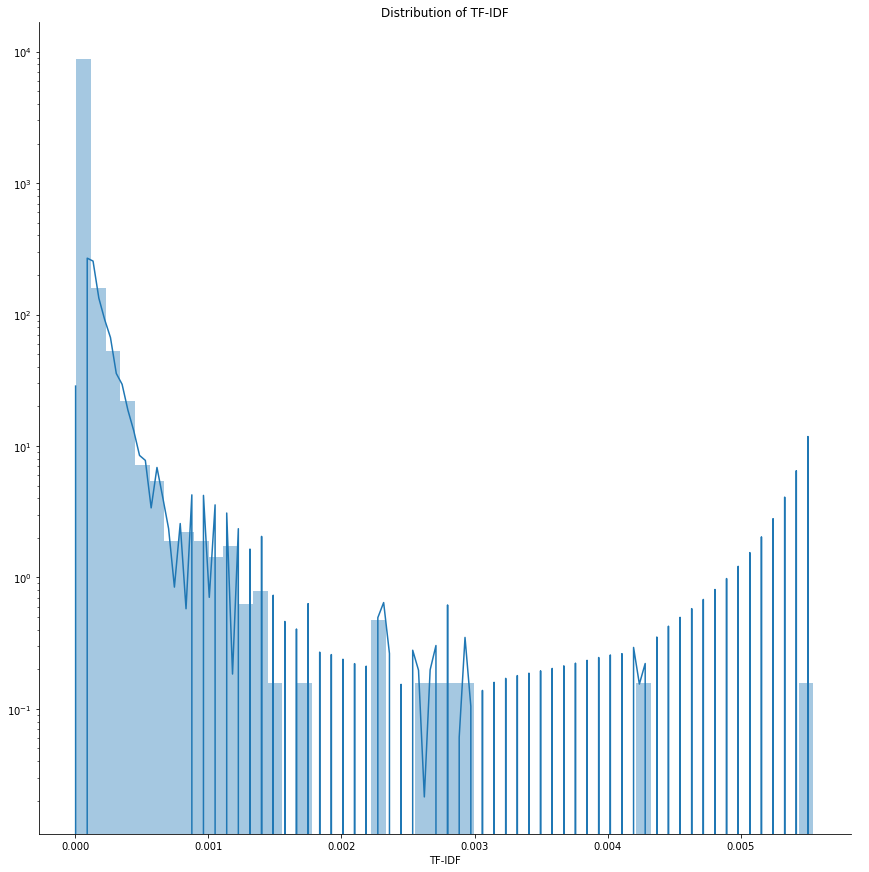

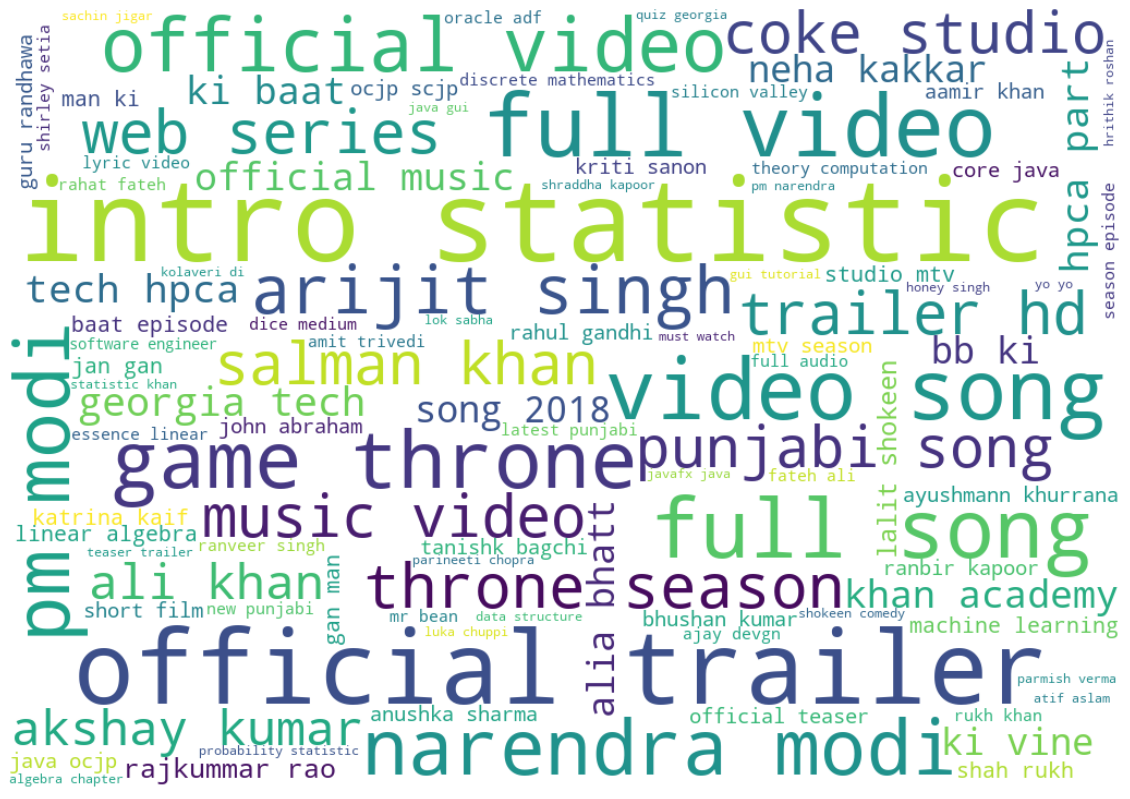

In [56]:
plot_word_cloud(corpus_title)

Shape: (16837, 250974)

Number of Unigrams 35022
Number of Bigram 215952
Number of terms 250974

#############Print the top 10 bigrams#############
hindi song
new song
bollywood song
course class
education engineering
programming education
class programming
narendra modi
computer science
song 2018




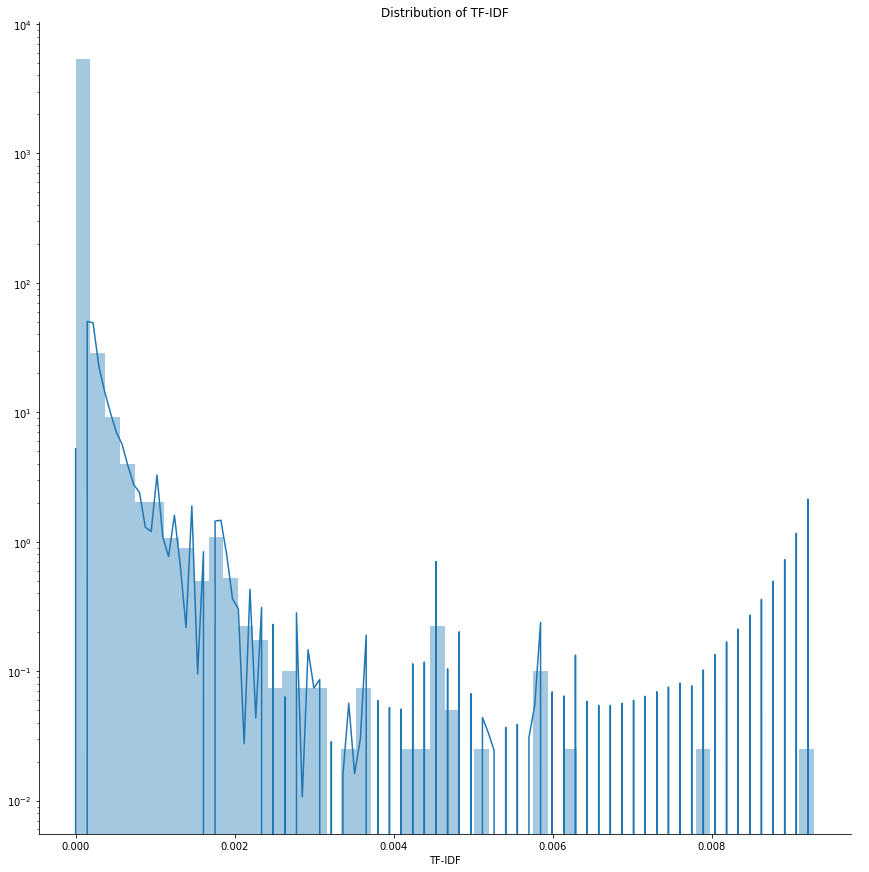

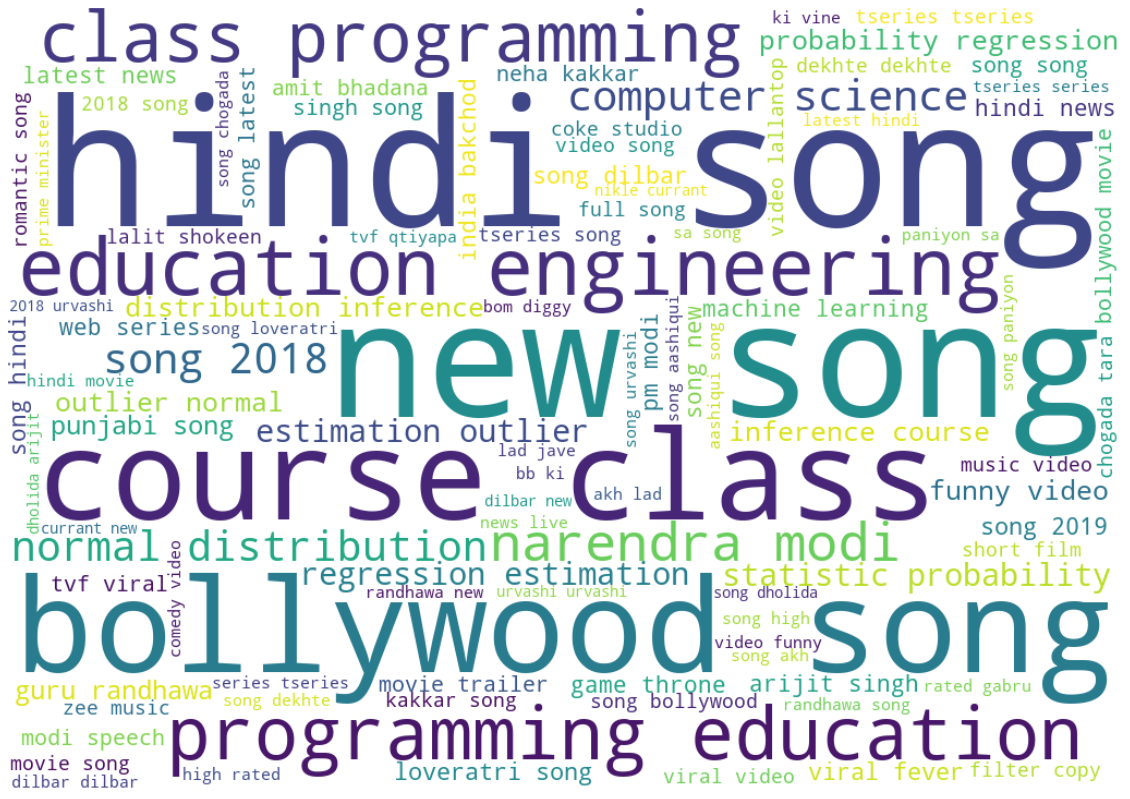

In [57]:
plot_word_cloud(corpus_tags_keywords_combined)

Shape: (17054, 619946)

Number of Unigrams 75172
Number of Bigram 544774
Number of terms 619946

#############Print the top 10 bigrams#############
subscriber sm
subscriber dial
youtube channel
online course
sm bt
narendra modi
computer science
facebook follow
like facebook
facebook twitter




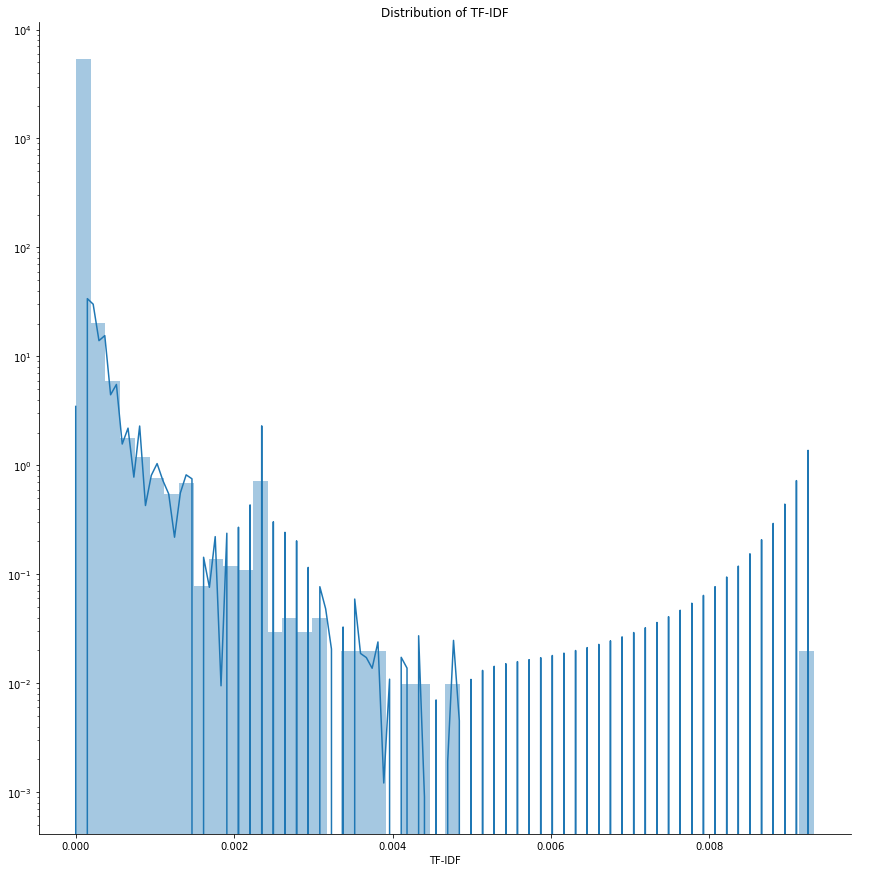

#############Print the sorted filter biagrams#############
gmail com
subscribe channel
magic music
prime minister
silicon valley
follow instagram
data science
discrete mathematics
music company
twitter instagram


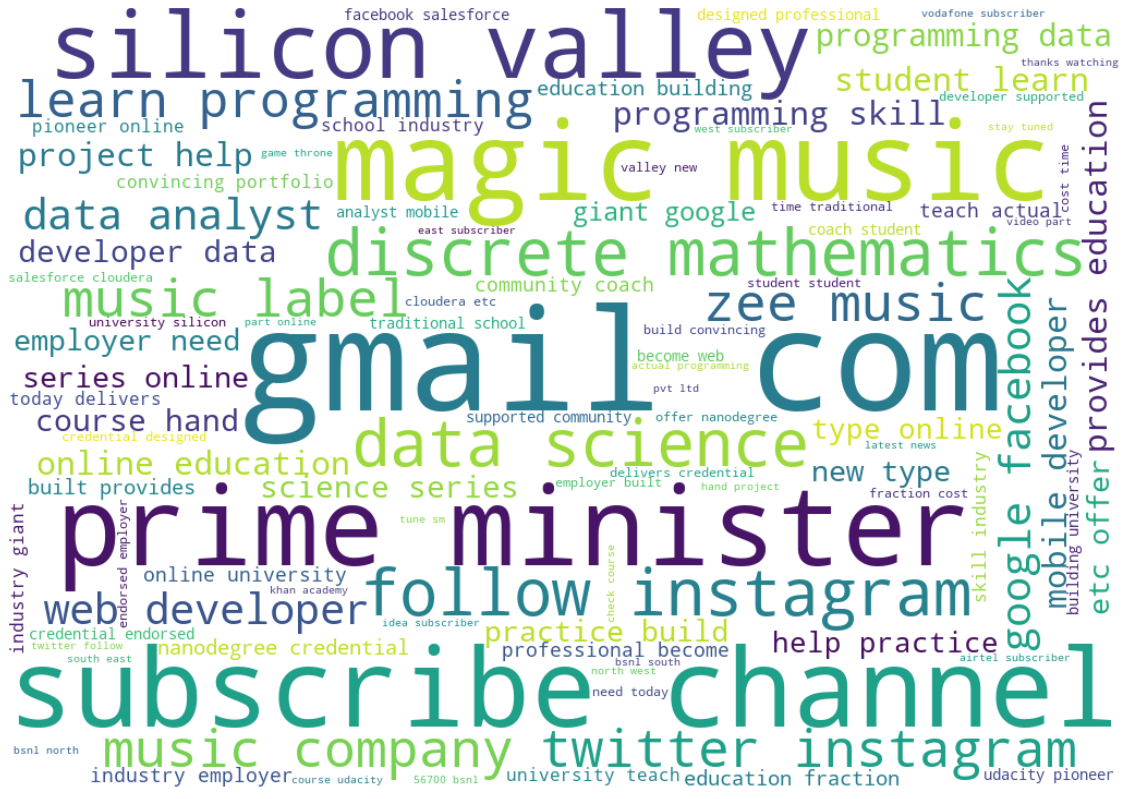

In [54]:
plot_word_cloud(corpus_video_channel_description_combined, isDescription=True)